In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
import cov_model_management as mm
import patsy


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))

# Impact of past severity on state measures

In [3]:
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing","TF4_Physiological_Anx", "TF5_Depression", "TF6_Cognitive_Anx"]
#trait_factor_names = [ "stai_ta", "bdi","cat", "sticsa_ta", "sticsa_cog_ta", "sticsa_som_ta"]


### Determine best window length
Usign aics isn't the best because data change
R2 seems to just increase (overfitting?) well at window = 9 the number of parameters is the same as data points so the fit is perfect

In [4]:
data = df.groupby(by="PROLIFICID")[["PROLIFICID"]+trait_factor_names].mean()
for tf in trait_factor_names:
    data[tf+"_ts"] = pd.qcut(data[tf], [0, .33, .66, 1],labels=['low', 'mid', 'high'])
    data[tf+"_ms"] = pd.qcut(data[tf], [0, .5, 1],labels=['low', 'high'])
    

KeyError: "Columns not found: 'TF4_Physiological_Anx', 'TF2_Positive', 'TF6_Cognitive_Anx', 'TF1_Self_Consciousness'"

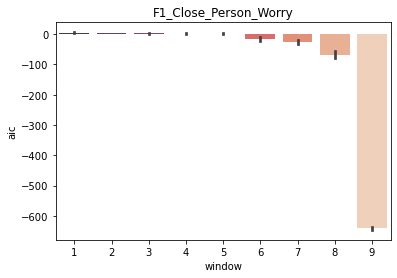

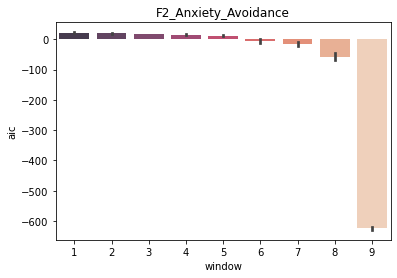

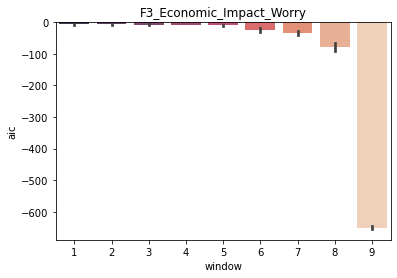

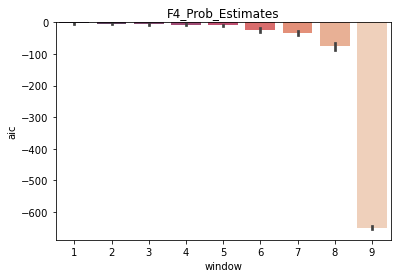

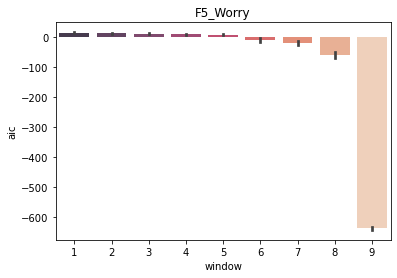

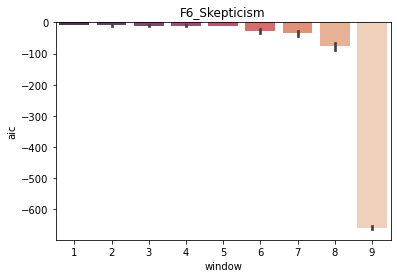

In [15]:
# flip in time, predict t1 with t234 etc
plot_var = "aic"
maxwin = 9
for f in factors:
    fdf = pd.DataFrame()
    
    for w in range(1,maxwin+1):
        tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", w).reset_index()
        tdf = tdf.loc[:,["PROLIFICID", plot_var]]
        tdf.loc[:,"window"] = str(w)
        tdf = tdf.set_index("PROLIFICID")
        tdf = tdf.join(data) 
        fdf = pd.concat([fdf, tdf])
        
    # plot R2 as a function of window size
    fig = plt.figure()
    #sns.stripplot(x="timepoint", y="beta",
    #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
    sns.barplot(x="window", y=plot_var,
                      dodge=True, data=fdf, alpha=.85, ci=68, 
                      zorder=1, palette=sns.color_palette("rocket", maxwin))
    plt.title(f)
        
    

In [6]:
fdf

r2 window  TF1_Self_Consciousness  TF2_Positive  \
PROLIFICID                                                                
01S0stEpc3rU6YxK  0.225324      1               -0.913516      0.483572   
05c9AaLx1V20UAcO  0.104707      1               -0.256844     -1.943311   
07GDvN1Nh0oHcEBM  0.042849      1                0.196950     -0.270619   
0OjnLzK5ABd2wO54  0.581339      1               -2.244184     -0.528596   
0Pe1blVigsBRLvBj  0.071496      1               -0.338332     -0.107202   
...                    ...    ...                     ...           ...   
zNbLeZqHa6wNHRLR       NaN     11               -0.251153     -1.762307   
zYWr4nlB9BwdVWFB  1.000000     11               -0.549587     -0.014385   
zZGJnUM65XIz0F0X  1.000000     11               -0.535923     -0.463178   
zlOEoLWEAwlLTGbE  1.000000     11                0.111479      0.187209   
ztPVSoIVH3QKpGeQ  1.000000     11               -0.785927     -1.576438   

                  TF3_Catastrophizing  TF4_Physiological_Anx  TF5_Depression  \
PROLIFICID                                                                     
01S0stEpc3rU6YxK             0.776880              -1.206655       -0.823695   
05c9AaLx1V20UAcO            -0.625601               0.808114        1.042578   
07GDvN1Nh0oHcEBM             0.690942               0.357304       -0.783261   
0OjnLzK5ABd2wO54            -0.358472              -0.052033        0.200290   
0Pe1blVigsBRLvBj             0.687559               0.596735       -0.388884   
...                               ...                    ...             ...   
zNbLeZqHa6wNHRLR            -0.238505              -0.077690       -0.680727   
zYWr4nlB9BwdVWFB            -0.478398              -0.420884        1.255617   
zZGJnUM65XIz0F0X            -0.333601              -0.307800       -0.583521   
zlOEoLWEAwlLTGbE             0.787422               0.229965        0.892838   
ztPVSoIVH3QKpGeQ            -0.891628              -0.091140       -0.228383   

                  TF6_Cognitive_Anx TF1_Self_Consciousness_ts  \
PROLIFICID                                                      
01S0stEpc3rU6YxK           1.868218                       low   
05c9AaLx1V20UAcO           0.322604                       mid   
07GDvN1Nh0oHcEBM          -0.024807                       mid   
0OjnLzK5ABd2wO54          -1.135049                       low   
0Pe1blVigsBRLvBj           0.566922                       mid   
...                             ...                       ...   
zNbLeZqHa6wNHRLR          -1.184221                       mid   
zYWr4nlB9BwdVWFB           0.791164                       mid   
zZGJnUM65XIz0F0X          -0.096455                       mid   
zlOEoLWEAwlLTGbE           0.673904                       mid   
ztPVSoIVH3QKpGeQ           0.278212                       low   

                 TF1_Self_Consciousness_ms TF2_Positive_ts TF2_Positive_ms  \
PROLIFICID                                                                   
01S0stEpc3rU6YxK                       low            high            high   
05c9AaLx1V20UAcO                       low             low             low   
07GDvN1Nh0oHcEBM                      high             mid             low   
0OjnLzK5ABd2wO54                       low             low             low   
0Pe1blVigsBRLvBj                       low             mid             low   
...                                    ...             ...             ...   
zNbLeZqHa6wNHRLR                       low             low             low   
zYWr4nlB9BwdVWFB                       low             mid            high   
zZGJnUM65XIz0F0X                       low             mid             low   
zlOEoLWEAwlLTGbE                      high             mid            high   
ztPVSoIVH3QKpGeQ                       low             low             low   

                 TF3_Catastrophizing_ts TF3_Catastrophizing_ms  \
PROLIFICID                                                       
01S0stEpc3rU6Y

### State severity on its own

Here, we are asking the question of how much does the state severity of previous time points impact the state factors 

In [16]:
### Meta parameters
window = 5 # two trials back
labels = ['t_min'+str(x) for x in range(0,window+1,1,)]

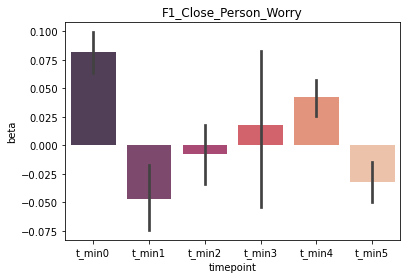

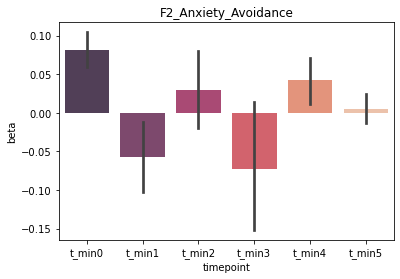

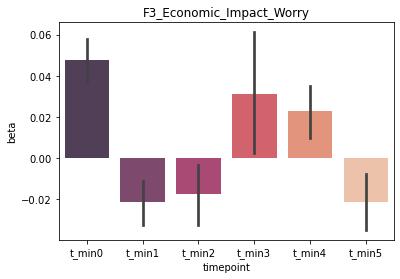

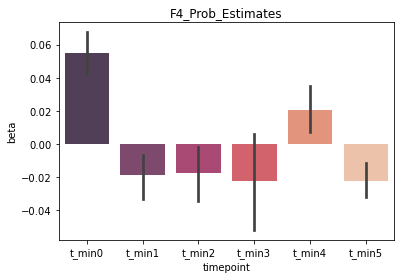

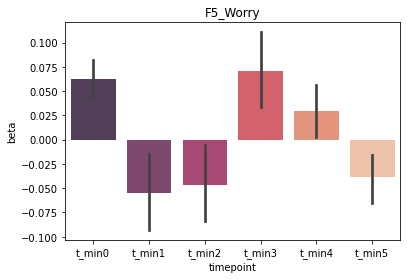

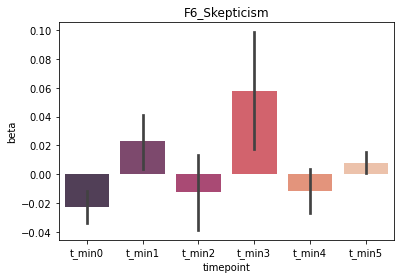

In [17]:
# chec for serial ortho

for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window)
    tdf = tdf.reset_index().drop(columns=["index", "level_1"])
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"], value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig = plt.figure()
    #sns.stripplot(x="timepoint", y="beta",
    #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
    sns.barplot(x="timepoint", y="beta",
                      dodge=True, data=tdf_long, alpha=.85, ci=68, 
                      zorder=1, palette=sns.color_palette("rocket", window+1))
    plt.title(f)


### State severity and trait factors

In [9]:
sc

''

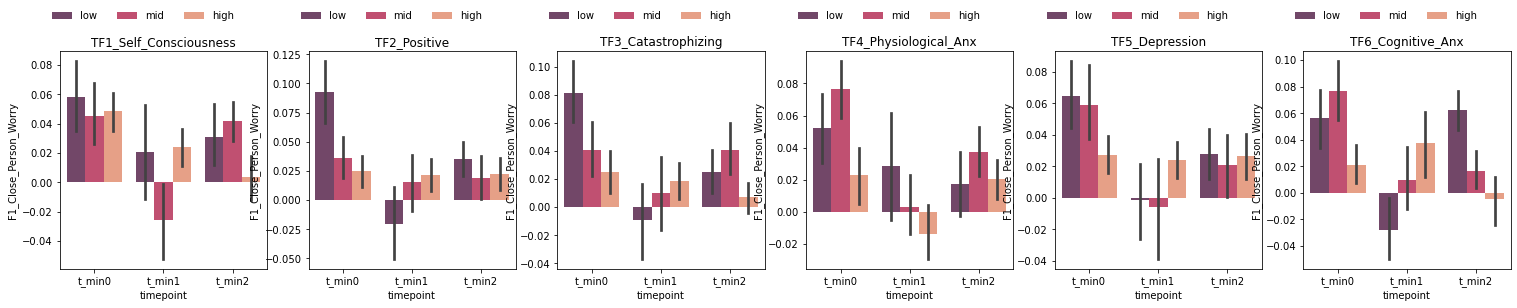

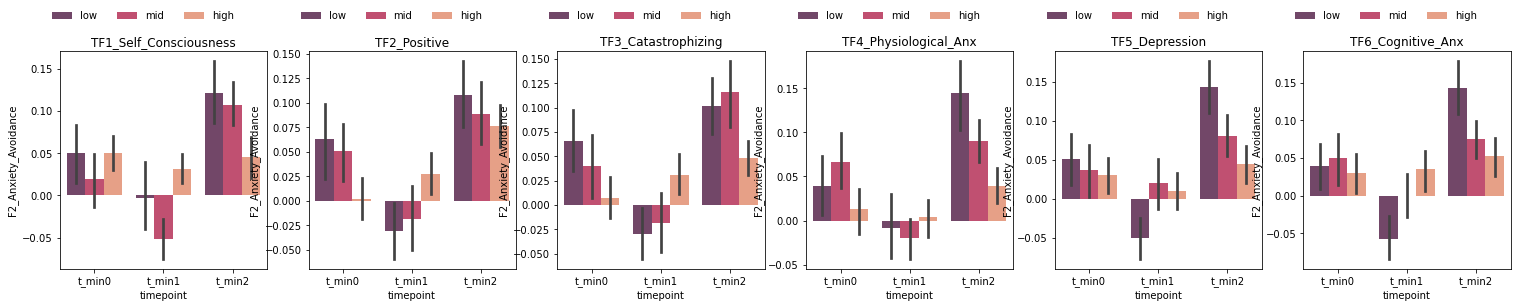

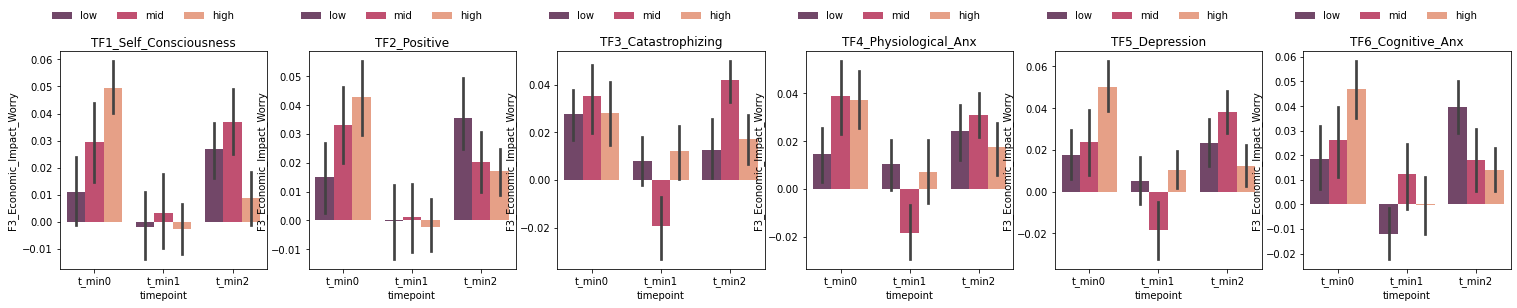

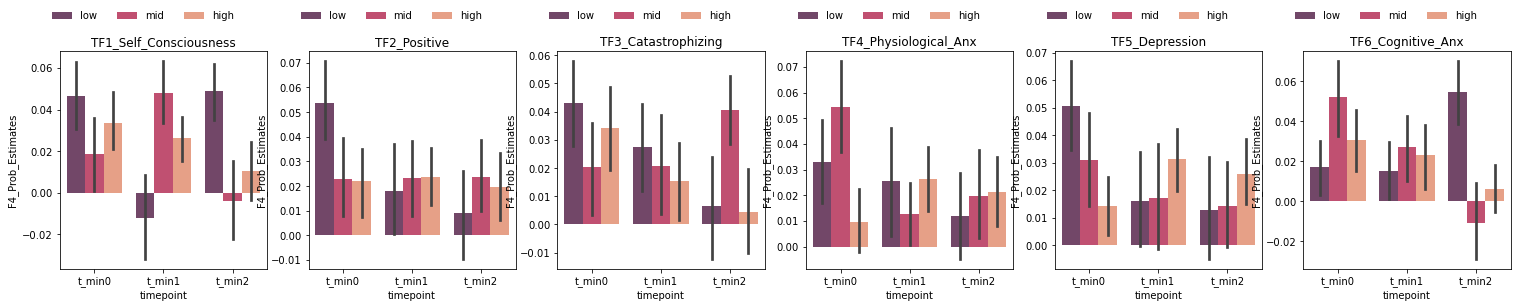

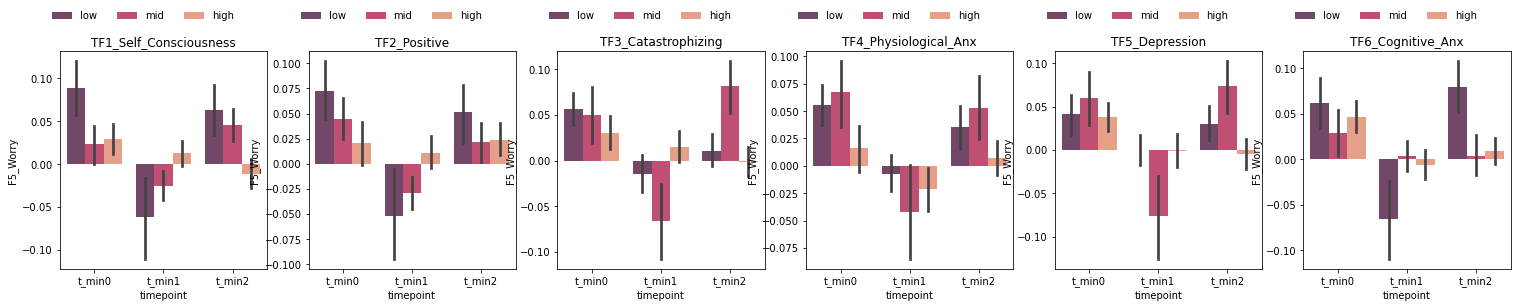

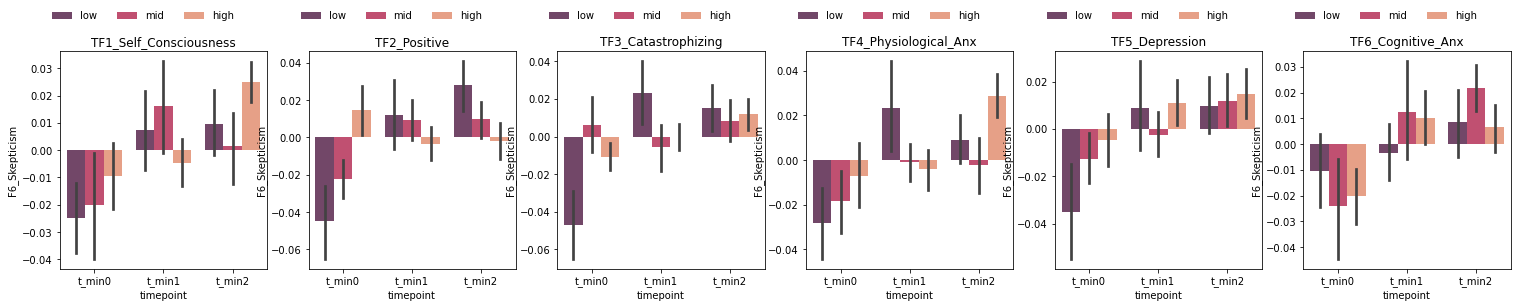

In [10]:


carryfwd = trait_factor_names + [x+"_ts" for x in trait_factor_names]
for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window)
    tdf = tdf.reset_index().drop(columns=["index", "level_1"]).set_index("PROLIFICID")
    tdf = tdf.join(data).reset_index()
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"]+carryfwd, value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(26,4))
    for tf_idx, tf in enumerate(trait_factor_names):
        #sns.stripplot(x="timepoint", y="beta",
        #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
        sns.barplot(x="timepoint", y="beta", hue=tf+"_ts", hue_order=["low", "mid", "high"],
                          dodge=True, data=tdf_long, alpha=.85, ci=68, 
                          zorder=1, palette=sns.color_palette("rocket", window+1), ax=ax[tf_idx])
        sns.move_legend(ax[tf_idx], "lower center", bbox_to_anchor=(0.4, 1.1), ncol=3, title=None, frameon=False)
        #ax[tf_idx].set_xlabel("Correlation with objective severity")
        ax[tf_idx].set_ylabel(f)
        ax[tf_idx].set_title(tf)
        
        

### Change in state severity and state measures

In [18]:
### Meta parameters
window = 2 # two trials back
labels = ['t_min'+str(x) for x in range(0,window+1,1,)]

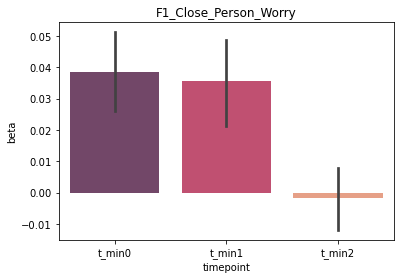

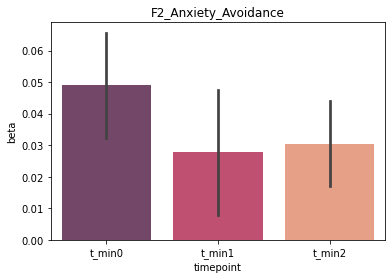

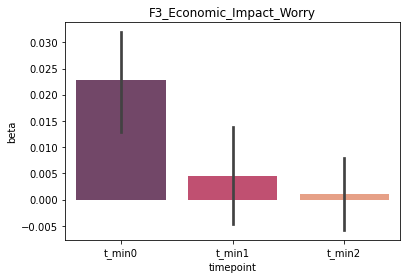

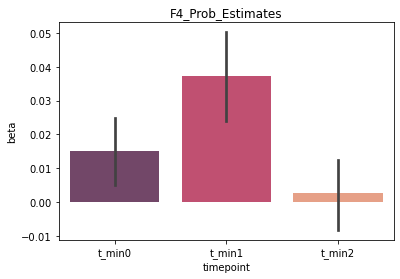

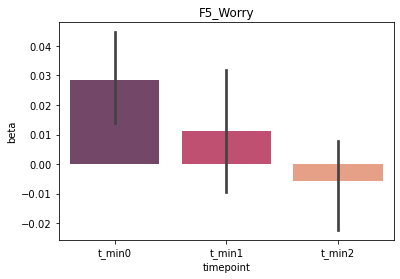

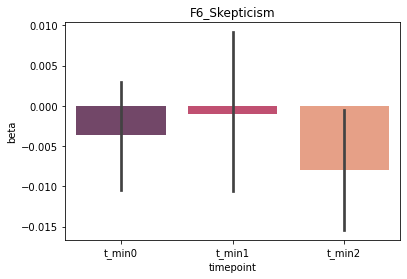

In [19]:


for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window, "changes")
    tdf = tdf.reset_index().drop(columns=["index", "level_1"])
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"], value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig = plt.figure()
    #sns.stripplot(x="timepoint", y="beta",
    #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
    sns.barplot(x="timepoint", y="beta",
                      dodge=True, data=tdf_long, alpha=.85, ci=68, 
                      zorder=1, palette=sns.color_palette("rocket", window+1))
    plt.title(f)


### Severity changes and trait measures

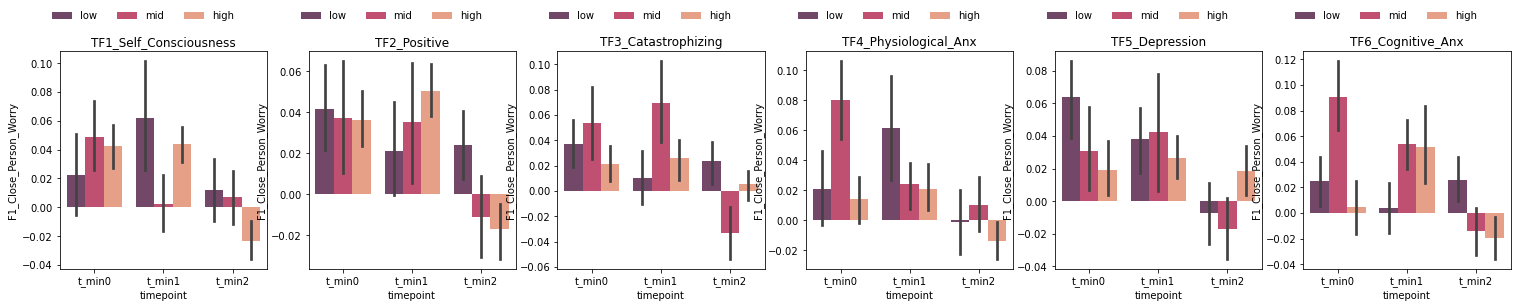

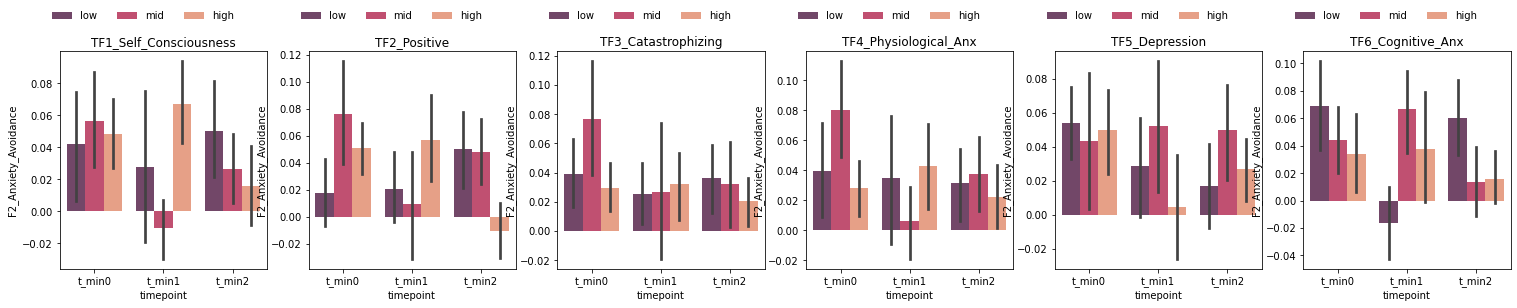

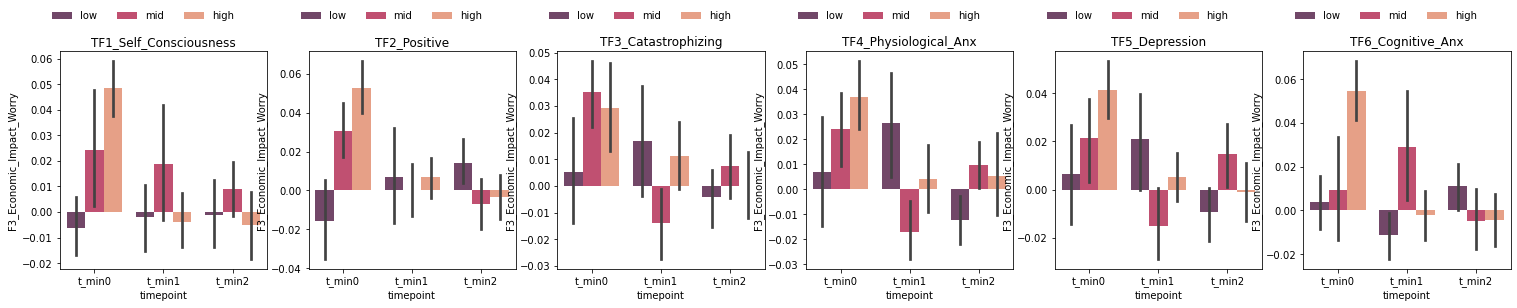

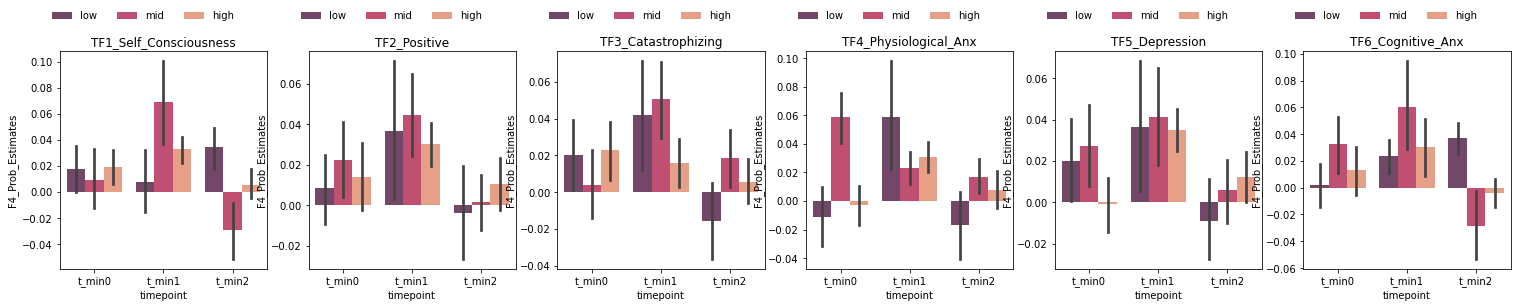

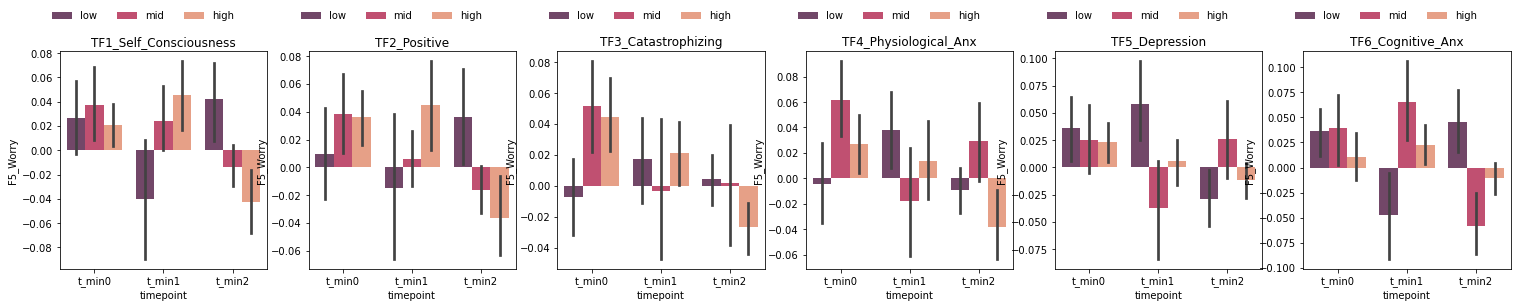

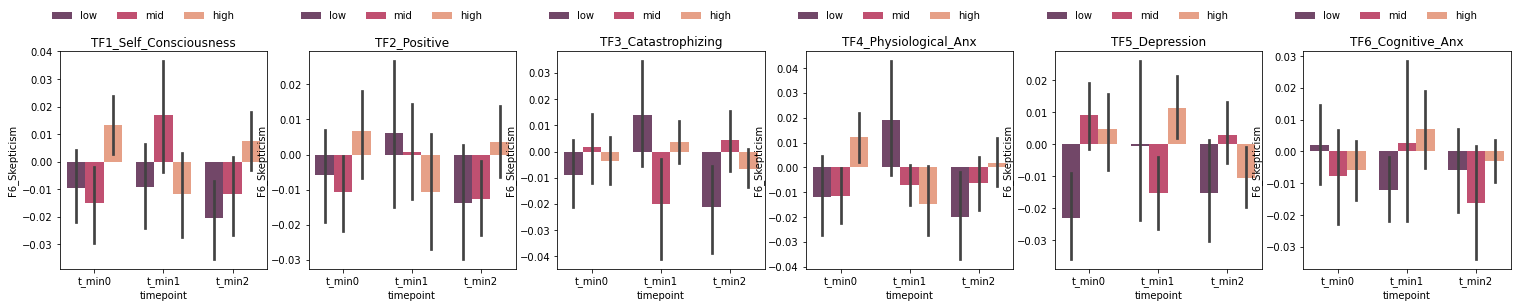

In [20]:
carryfwd = trait_factor_names + [x+"_ts" for x in trait_factor_names]
for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window, "changes")
    tdf = tdf.reset_index().drop(columns=["index", "level_1"]).set_index("PROLIFICID")
    tdf = tdf.join(data).reset_index()
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"]+carryfwd, value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(26,4))
    for tf_idx, tf in enumerate(trait_factor_names):
        #sns.stripplot(x="timepoint", y="beta",
        #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
        sns.barplot(x="timepoint", y="beta", hue=tf+"_ts", hue_order=["low", "mid", "high"],
                          dodge=True, data=tdf_long, alpha=.85, ci=68, 
                          zorder=1, palette=sns.color_palette("rocket", window+1), ax=ax[tf_idx])
        sns.move_legend(ax[tf_idx], "lower center", bbox_to_anchor=(0.4, 1.1), ncol=3, title=None, frameon=False)
        #ax[tf_idx].set_xlabel("Correlation with objective severity")
        ax[tf_idx].set_ylabel(f)
        ax[tf_idx].set_title(tf)

In [14]:
tdf = df.groupby(by="PROLIFICID")[["state_severity", factors[0]]].apply(run_VAR_single, factors[0], "state_severity", 2, "changes").reset_index()